# Predicció de Freqüència Cardíaca en Ciclisme 🚴‍♂️ 

**Objectiu:**  
Comparar el rendiment de tres models de *Deep Learning*:
- Multi$-$Layer Perceptron (MLP)
- Recurrent Neural Networks (RNN)
- Long$-$Short Term Memory (LSTM)

**Dades Utilitzades:**
- **Variables d'entrada:**  
    Freqüència cardíaca ($bpm$); potència ($w$); cadència ($rpm$); Velocitat ($m/s$); Altitud $m$ 
- **Variable objectiu:**  
    Freqüència cardíaca ($bpm$) 

In [72]:
# Essential libraries
import os
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Logging configuration
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Processament de les dades

### Execució i visualització de dades

In [75]:
# Load the concatenated dataset
df_concatenated = pd.read_csv("concatenated_data.csv")

# Display the first 3 rows of the DataFrame
display(df_concatenated.head(3))

# Print the list of available columns
print(f"- Available columns: {list(df_concatenated.columns)}")

timestamp  heart_rate  cadence  distance  power  temperature  speed  \
0          1          90     59.0      6.19  142.0           28  2.855   
1          2          90     66.0      9.70  111.0           28  3.294   
2          3          90     66.0     13.85    4.0           28  3.956   

   altitude  alt_difference  rolling_ave_alt    power_ma  cadence_ma  \
0        53               0              0.0  142.000000   59.000000   
1        53               0              0.0  126.500000   62.500000   
2        53               0              0.0   85.666667   63.666667   

            source_file  
0  cycling_2024_08_06_1  
1  cycling_2024_08_06_1  
2  cycling_2024_08_06_1

- Available columns: ['timestamp', 'heart_rate', 'cadence', 'distance', 'power', 'temperature', 'speed', 'altitude', 'alt_difference', 'rolling_ave_alt', 'power_ma', 'cadence_ma', 'source_file']


### Tria de les variables

Aquesta funció converteix el `DataFrame` en arrays `numpy`, separant la variable objectiu (`heart_rate`) de les variables explicatives.

- Si no s’especifiquen columnes, es seleccionen totes les columnes numèriques excepte la variable objectiu.
- Els arrays resultants són del tipus `float32`, preparats per a ser emprats en models de xarxes neuronals.
- Finalment, es mostra una petita mostra per verificar que la conversió s’ha realitzat correctament.

In [77]:
def prepare_arrays(df, target_col='heart_rate', feature_cols=None):
    """
    Convert a DataFrame into numpy arrays for modeling.
    """
    # Select feature columns
    if feature_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        feature_cols = [col for col in numeric_cols if col != target_col]

    # Convert target and features to float32 arrays
    target_array = df[target_col].values.astype(np.float32)
    feature_array = df[feature_cols].values.astype(np.float32)

    return target_array, feature_array

# Prepare arrays
selected_columns = ['heart_rate', 'power_ma', 'cadence', 'rolling_ave_alt']
target_array, feature_array = prepare_arrays(df_concatenated, feature_cols=selected_columns)

# Inspect results
print("\nSample arrays:")
print(f"target_array (first 5): {target_array[:5]}")
print(f"feature_array shape: {feature_array.shape}")
print(f"first row: {feature_array[0]}")



Sample arrays:
target_array (first 5): [90. 90. 90. 89. 88.]
feature_array shape: (397648, 4)
first row: [ 90. 142.  59.   0.]


### Normalització i verificació de les dades

Abans d'entrenar un model és important que les dades estiguin en una escala comuna. Aquesta cel·la aplica una **normalització estàndard (z-score)** a les dades:

1. **Normalització**
   - `heart_rate` i les *features* es normalitzen utilitzant `StandardScaler`.
   - El resultat són dues matrius amb mitjana zero i desviació estàndard u.

2. **Verificació**
   - Es desnormalitzen les dades per comprovar que es poden recuperar els valors originals amb precisió.
   - La funció `np.allclose` assegura que la diferència és negligible.

3. **Exemple concret**
   - Es mostra un cas amb un sol registre per veure la transformació real: original → normalitzat → desnormalitzat.

Aquesta normalització és fonamental per garantir una **convergència estable i eficaç** en els models de *deep learning*.


In [79]:
def normalize_arrays(target_array, feature_array):
    """
    Normalize the target and feature arrays using StandardScaler.
    """
    target_scaler = StandardScaler()
    feature_scaler = StandardScaler()

    target_norm = target_scaler.fit_transform(target_array.reshape(-1, 1)).flatten()
    feature_norm = feature_scaler.fit_transform(feature_array)

    return target_norm, feature_norm, (target_scaler, feature_scaler)

def denormalize_arrays(target_norm, feature_norm, scalers):
    """
    Restore original values from normalized arrays.
    """
    target_scaler, feature_scaler = scalers

    target_original = target_scaler.inverse_transform(target_norm.reshape(-1, 1)).flatten()
    feature_original = feature_scaler.inverse_transform(feature_norm)

    return target_original, feature_original

# --- Run normalization ---
target_norm, feature_norm, scalers = normalize_arrays(target_array, feature_array)

# Show results
print("\nNormalized arrays:")
print(f"target_norm (first 5): {target_norm[:5]}")
print(f"feature_norm (first row): {feature_norm[0]}")
print(f"feature_norm mean per column: {np.mean(feature_norm, axis=0)}")

# Verify inverse transformation
target_recovered, feature_recovered = denormalize_arrays(target_norm, feature_norm, scalers)

print("\nDenormalization check:")
print(f"target match: {np.allclose(target_array[:100], target_recovered[:100], atol=1e-5)}")
print(f"features match: {np.allclose(feature_array[:100], feature_recovered[:100], atol=1e-5)}")

# Example
i = 0
print("\nExample:")
print(f"Original      – HR: {target_array[i]}, Features: {feature_array[i]}")
print(f"Normalized    – HR: {target_norm[i]:.4f}, Features: {[f'{x:.4f}' for x in feature_norm[i]]}")
print(f"Denormalized  – HR: {target_recovered[i]}, Features: {feature_recovered[i]}")



Normalized arrays:
target_norm (first 5): [-2.9742124 -2.9742124 -2.9742124 -3.0308201 -3.0874276]
feature_norm (first row): [-2.9742124e+00 -9.5305896e-01 -1.5545293e+00  1.0569171e-03]
feature_norm mean per column: [-6.1396166e-10  5.5256550e-09  3.2232987e-09 -8.2117371e-09]

Denormalization check:
target match: True
features match: True

Example:
Original      – HR: 90.0, Features: [ 90. 142.  59.   0.]
Normalized    – HR: -2.9742, Features: ['-2.9742', '-0.9531', '-1.5545', '0.0011']
Denormalized  – HR: 90.0, Features: [ 9.000000e+01  1.420000e+02  5.900000e+01 -5.558922e-12]


### Creació dels datasets temporals

Aquesta cel·la transforma les dades normalitzades en conjunts de dades per a models seqüencials.

- Es divideixen les dades en **entrenament (70%)**, **validació (15%)** i **test (15%)**.
- Cada entrada consisteix en una seqüència temporal de longitud `sequence_length` i un valor objectiu que es troba `delay` passos endavant.
- S’utilitza la utilitat `timeseries_dataset_from_array` de Keras per generar els *batches* de manera eficient.
- Finalment, s’inspecciona el primer batch d’entrenament per confirmar la forma de les dades.

Aquest pas és essencial per adaptar les dades a xarxes neuronals recurrents o models seqüencials tipus MLP, RNN o LSTM.


In [81]:
def create_timeseries_datasets(features, target,
                                train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                sequence_length=40, delay=50, sampling_rate=1,
                                batch_size=256):
    """
    Create training, validation and test datasets for time series modeling.
    """
    total_samples = len(features) - delay - sequence_length
    n_train = int(total_samples * train_ratio)
    n_val = int(total_samples * val_ratio)
    n_test = total_samples - n_train - n_val

    train_ds = keras.utils.timeseries_dataset_from_array(
        features[:-delay], targets=target[delay:],
        sampling_rate=sampling_rate, sequence_length=sequence_length,
        batch_size=batch_size, start_index=0, end_index=n_train)

    val_ds = keras.utils.timeseries_dataset_from_array(
        features[:-delay], targets=target[delay:],
        sampling_rate=sampling_rate, sequence_length=sequence_length,
        batch_size=batch_size, start_index=n_train, end_index=n_train + n_val)

    test_ds = keras.utils.timeseries_dataset_from_array(
        features[:-delay], targets=target[delay:],
        sampling_rate=sampling_rate, sequence_length=sequence_length,
        batch_size=batch_size, start_index=n_train + n_val)

    dataset_info = {
        'train_samples': n_train,
        'val_samples': n_val,
        'test_samples': n_test,
        'sequence_length': sequence_length,
        'delay': delay,
        'sampling_rate': sampling_rate,
        'input_shape': (sequence_length // sampling_rate, features.shape[-1]),
        'total_samples': total_samples
    }

    return train_ds, val_ds, test_ds, dataset_info

# --- Run ---
train_ds, val_ds, test_ds, ds_info = create_timeseries_datasets(
    feature_norm, target_norm,
    train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
    sequence_length=60, delay=70, sampling_rate=1,
    batch_size=256
)

# Inspect first batch
for batch, targets in train_ds.take(1):
    print("\nFirst training batch:")
    print(f"- Features shape: {batch.shape} (batch, timesteps, features)")
    print(f"- Targets shape: {targets.shape}")
    print(f"- Input shape: {ds_info['input_shape']}")



First training batch:
- Features shape: (256, 60, 4) (batch, timesteps, features)
- Targets shape: (256,)
- Input shape: (60, 4)


### Callbacks per a l'entrenament

Aquesta funció defineix els **callbacks estàndard** utilitzats durant l'entrenament dels models:

- `EarlyStopping`: atura l'entrenament si la mètrica de validació no millora després de diversos epochs, i recupera els pesos del millor model.
- `ModelCheckpoint`: desa automàticament els pesos del millor model segons la mètrica especificada.

Els callbacks contribueixen a evitar l'*overfitting* i a garantir que el model entrenat final sigui el més eficient obtingut durant el procés.


In [83]:
def get_callbacks(monitor='val_loss',
                  checkpoint_path='best_model.weights.h5',
                  early_patience=15,
                  lr_patience=8,
                  log_dir=None):
    """
    Define standard callbacks for model training.
    """
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=early_patience,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=monitor,
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )
    ]
    return callbacks


## Multi$-$Layer Perceptron (MLP)

### Arquitectura del model: MLP

Es defineix un **model de perceptró multicapa (MLP)** senzill per a la predicció de la freqüència cardíaca a partir de seqüències temporals de variables fisiològiques.

- **Entrada**: seqüències de longitud fixa amb diverses característiques (*features*).
- **GlobalAveragePooling1D**: redueix la dimensió temporal mitjançant una mitjana, simplificant l'entrada per a la capa densa.
- **Capa densa oculta**: amb 4 neurones i activació `tanh`.
- **Capa de sortida**: una única neurona amb activació lineal per predicció contínua.
- El model es compila amb:
  - Optimitzador `Adam`
  - Pèrdua `mean squared error (mse)`
  - Mètriques: `mae` i `mse`

Aquest model actuarà com a punt de partida per a comparar amb arquitectures més complexes.


In [86]:
def build_mlp(input_shape):
    """
    Build a MLP for time series regression.
    """
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.GlobalAveragePooling1D()(inputs)
    x = keras.layers.Dense(4, activation='tanh')(x)
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model


### Entrenament del model MLP

En aquesta secció s’entrena el model MLP definit anteriorment amb les dades preparades.

1. **Input shape**: s’obté de la configuració del dataset temporal.
2. **Construcció del model**: es crea un model MLP senzill amb una capa oculta.
3. **Callbacks**: s’utilitzen els callbacks definits prèviament per controlar l’entrenament (EarlyStopping i ModelCheckpoint).
4. **Entrenament**: el model s’entrena durant un màxim de 100 èpoques, monitoritzant la pèrdua de validació.

Aquest entrenament servirà com a base de comparació amb models seqüencials més avançats.


In [88]:
# 1. Input shape
input_shape = ds_info['input_shape']
print(f"\nModel input shape: {input_shape}")

# 2. Build the MLP model
model_mlp = build_mlp(input_shape)
model_mlp.summary()

# 3. Get callbacks
callbacks = get_callbacks(
    checkpoint_path="best_model_mlp.weights.h5",
    log_dir='./logs/mlp'
)

# 4. Train the model
print("\nStarting MLP training...")
history = model_mlp.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)



Model input shape: (60, 4)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 60, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 4)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)


Starting MLP training...
Epoch 1/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.4402 - mae: 0.4929 - mse: 0.4402 - val_loss: 0.3033 - val_mae: 0.3976 - val_mse: 0.3033
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.2710 - mae: 0.3746 - mse: 0.2710 - val_loss: 0.2804 - val_mae: 0.3787 - val_mse: 0.2804
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.2401 - mae: 0.3468 - mse: 0.2401 - val_loss: 0.2803 - val_mae: 0.3784 - val_mse: 0.2803
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2304 - mae: 0.3370 - mse: 0.2304 - val_loss: 0.2802 - val_mae: 0.3782 - val_mse: 0.2802
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.2272 - mae: 0.3333 - mse: 0.2272 - val_loss: 0.2788 - val_mae: 0.3772 - val_mse: 0.2788
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.2254 - mae: 0.3313 - mse: 0.2254 - val_loss: 0.2772 - val_mae: 0.3762 - val_mse: 0.2772
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1

### Visualització de l'evolució de l'entrenament

Es mostra la corba de pèrdua durant les diferents èpoques d'entrenament:

- S’hi comparen la **pèrdua d'entrenament** i la **pèrdua de validació** per observar la convergència i detectar sobreajust.
- La figura es guarda automàticament en format PDF dins la carpeta `prediction_plots`.

Aquest gràfic és útil per interpretar el comportament del model al llarg de l'entrenament i avaluar la seva estabilitat.


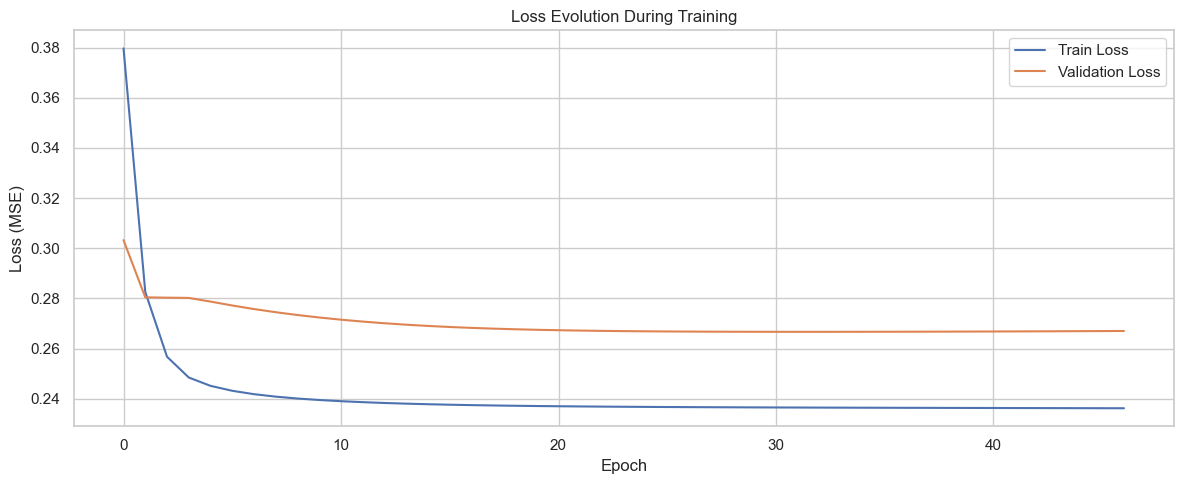

In [90]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()

# Save figure
os.makedirs('prediction_plots_mlp', exist_ok=True)
plt.savefig('prediction_plots_mlp/loss.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Avaluació del model amb dades de test

En aquesta cel·la s'avalua el rendiment del model MLP sobre mostres no vistes del conjunt de test.

- Es prenen 20 *batches* del test set.
- Les prediccions i valors reals es **desnormalitzen** per comparar-les en bpm reals.
- Es calcula:
  - **MAE (Mean Absolute Error)** per batch
  - **Desviació estàndard de l’error**
  - **Error màxim**

Finalment, es mostren les **mitjanes de cada mètrica**, oferint una estimació global de la precisió del model.


In [92]:
print("\nEvaluating model on test data...")

total_mae = 0
total_std = 0
total_max_error = 0
batch_count = 0
n = 20

# Evaluate over n batches from the test set
for i, (x_test, y_test_norm) in enumerate(test_ds.take(n)):
    y_test_norm = y_test_norm.numpy()
    y_pred_norm = model_mlp.predict(x_test).flatten()

    # Denormalize predictions and targets
    y_test = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()

    # Compute metrics
    mae = np.mean(np.abs(y_test - y_pred))
    std = np.std(y_test - y_pred)
    max_error = np.max(np.abs(y_test - y_pred))

    total_mae += mae
    total_std += std
    total_max_error += max_error
    batch_count += 1

    print(f"\nBatch {i+1} — Performance (bpm):")
    print(f"- MAE: {mae:.1f}")
    print(f"- Std of error: {std:.1f}")
    print(f"- Max error: {max_error:.1f}")

# Average metrics across batches
avg_mae = total_mae / batch_count
avg_std = total_std / batch_count
avg_max_error = total_max_error / batch_count

print("\n" + "="*50)
print("AVERAGE PERFORMANCE OVER 20 BATCHES:")
print(f"- Mean MAE: {avg_mae:.1f} bpm")
print(f"- Mean Std of Error: {avg_std:.1f} bpm")
print(f"- Mean Max Error: {avg_max_error:.1f} bpm")
print("="*50)


Evaluating model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Batch 1 — Performance (bpm):
- MAE: 9.6
- Std of error: 11.4
- Max error: 25.9
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Batch 2 — Performance (bpm):
- MAE: 4.0
- Std of error: 4.8
- Max error: 11.3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Batch 3 — Performance (bpm):
- MAE: 1.8
- Std of error: 2.4
- Max error: 8.0
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Batch 4 — Performance (bpm):
- MAE: 5.4
- Std of error: 6.5
- Max error: 16.1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Batch 5 — Performance (bpm):
- MAE: 2.9
- Std of error: 3.4
- Max error: 8.2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Batch 6 — Performance (bpm):
- MAE: 3.7
- Std of error: 5.4
- Max error: 14.5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Batch 7 — Performance (bpm):
- MAE: 3.8
- Std of error: 4.3
- Max error: 9.6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Batch 8 — Performance (bpm):
- MAE: 2.8
- Std of error: 3.4
- Max error: 6.6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

### Comparació entre dades reals i prediccions

En aquesta cel·la es realitza una comparació entre les dades reals i prediccions corresponents a les dades del conjunt de test.

- Es prenen 5 *batches* del test set.
- Es dibuixen gràfics on la línia blava són les dades reals i la línia taronja ratllada són les prediccions
- La zona ombrajada és el marge d'error que ve donat pel MAE del lot.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


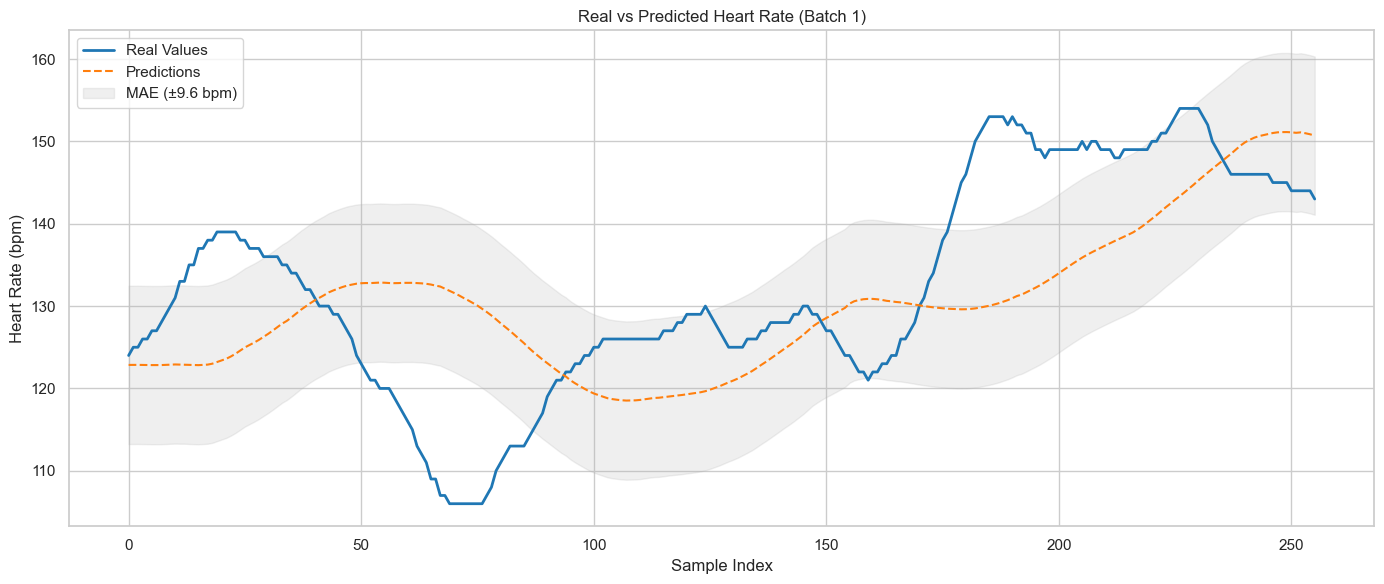

Batch 1 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


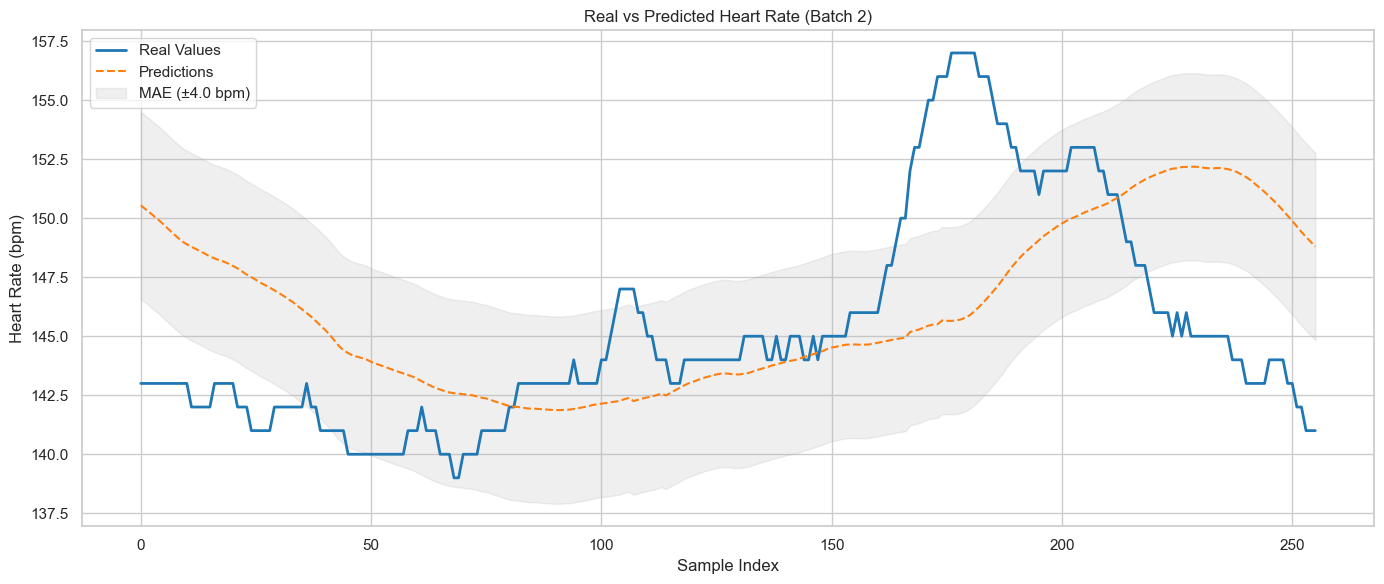

Batch 2 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


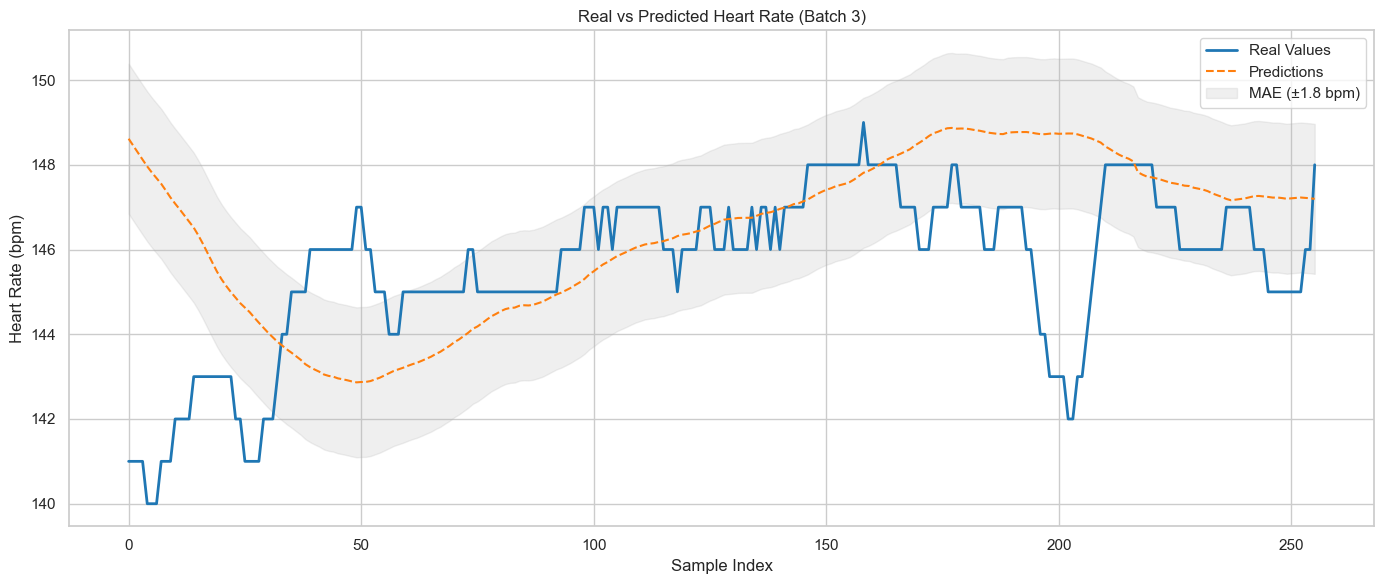

Batch 3 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


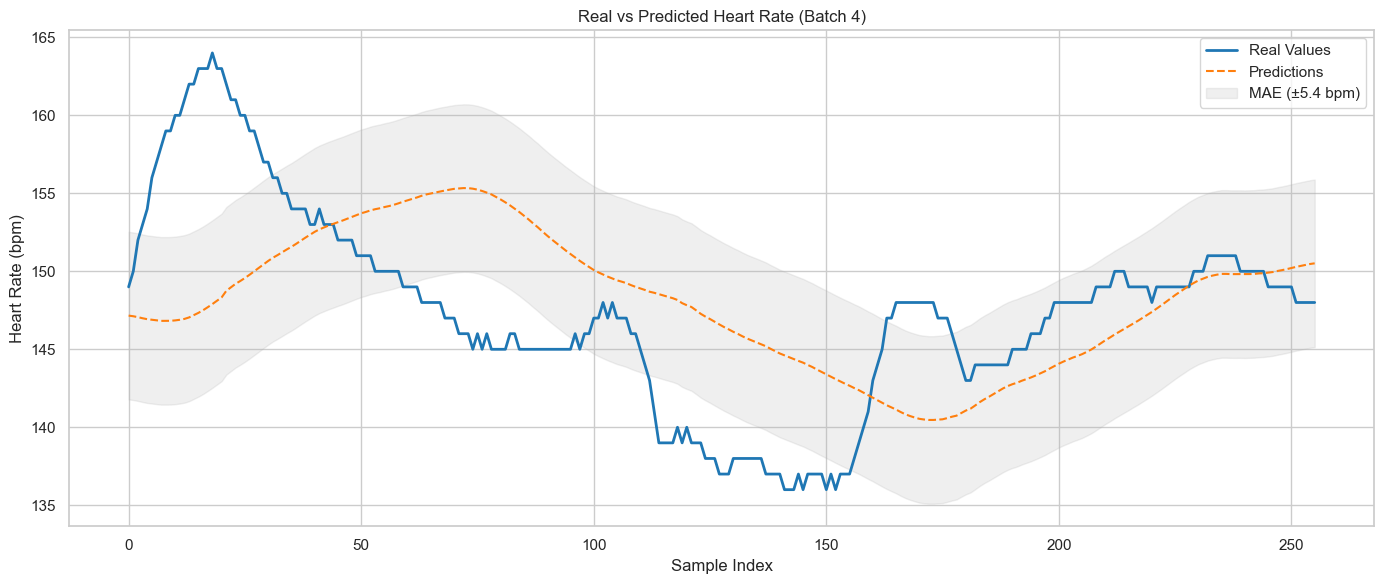

Batch 4 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


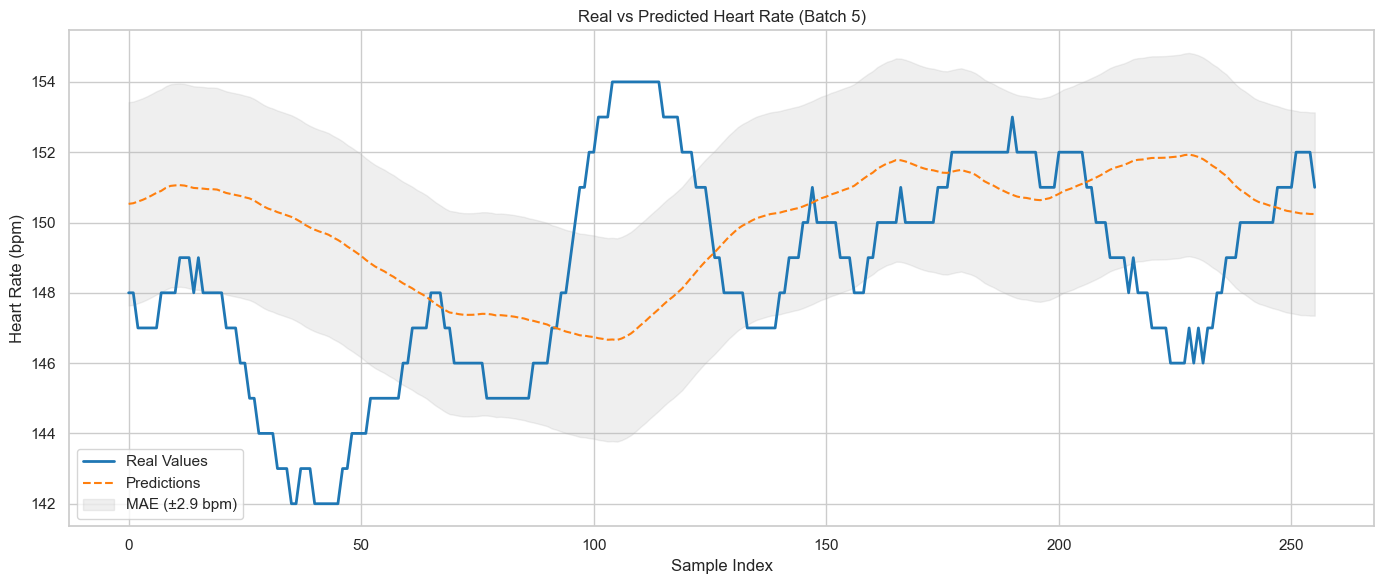

Batch 5 saved:


In [93]:
# Create output directory if it doesn't exist
output_dir = 'prediction_plots_mlp'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set(style='whitegrid')
plt.rcParams['font.size'] = 12

# Colors
color_real = '#1f77b4'      # blue
color_pred = '#ff7f0e'      # orange
color_error = '#b0b0b0'     # light gray

# Process 5 batches from test set
for i, batch in enumerate(test_ds.take(5)):
    x_test, y_test_norm = batch
    y_test_norm = y_test_norm.numpy()
    
    # Get predictions
    y_pred_norm = model_mlp.predict(x_test).flatten()
    
    # Convert back to original scale
    y_test_real = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred_real = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    
    # Calculate MAE
    mae_bpm = np.mean(np.abs(y_test_real - y_pred_real))
    n_samples = len(y_test_real)

    # ===== LINE PLOT =====
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Real Values', color=color_real, linewidth=2)
    plt.plot(y_pred_real, label='Predictions', color=color_pred, linestyle='--', linewidth=1.5)
    
    # Add error band
    plt.fill_between(
        range(n_samples),
        y_pred_real - mae_bpm,
        y_pred_real + mae_bpm,
        color=color_error,
        alpha=0.2,
        label=f'MAE (±{mae_bpm:.1f} bpm)'
    )
    
    plt.title(f'Real vs Predicted Heart Rate (Batch {i+1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plots
    line_pdf = os.path.join(output_dir, f'predictions_batch_{i+1}.pdf')
    plt.savefig(line_pdf)
    plt.show()

    print(f"Batch {i+1} saved:")

## Recurrent Neural Networks (RNN)

### Arquitectura del model: RNN

Es defineix un **model recurrent (RNN)** senzill per a la predicció de la freqüència cardíaca a partir de seqüències temporals de variables fisiològiques.

- **Entrada**: seqüències de longitud fixa amb diverses característiques (*features*).
- **Capa recurrent oculta**: amb 4 neurones i activació `tanh`.
- **Capa de sortida**: una única neurona amb activació lineal per predicció contínua.
- El model es compila amb:
  - Optimitzador `Adam`
  - Pèrdua `mean squared error (mse)`
  - Mètriques: `mae` i `mse`


In [95]:
def build_simple_rnn(input_shape):
    """
    Build a simple RNN for time series regression.
    """
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.SimpleRNN(4, activation='tanh')(inputs)
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

In [96]:
# 1. Input shape
input_shape = ds_info['input_shape']
print(f"\nModel input shape: {input_shape}")

# 2. Build the Simple RNN model
model_simple_rnn = build_simple_rnn(input_shape)
model_simple_rnn.summary()

# 3. Get callbacks
callbacks = get_callbacks(
    checkpoint_path="best_model_simple_rnn.weights.h5",
    log_dir='./logs/simple_rnn'
)

# 4. Train the model
print("\nStarting Simple RNN training...")
history = model_simple_rnn.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)



Model input shape: (60, 4)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 60, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)


Starting Simple RNN training...
Epoch 1/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.1920 - mae: 0.3221 - mse: 0.1920 - val_loss: 0.1008 - val_mae: 0.2254 - val_mse: 0.1008
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0946 - mae: 0.2132 - mse: 0.0946 - val_loss: 0.0784 - val_mae: 0.1921 - val_mse: 0.0784
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0720 - mae: 0.1799 - mse: 0.0720 - val_loss: 0.0737 - val_mae: 0.1857 - val_mse: 0.0737
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0672 - mae: 0.1725 - mse: 0.0672 - val_loss: 0.0719 - val_mae: 0.1834 - val_mse: 0.0719
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0651 - mae: 0.1690 - mse: 0.0651 - val_loss: 0.0708 - val_mae: 0.1821 - val_mse: 0.0708
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.0638 - mae: 0.1669 - mse: 0.0638 - val_loss: 0.0702 - val_mae: 0.1812 - val_mse: 0.0702
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━

### Avaluació del model

De la mateixa manera que a l'apartat anterior, s'avalua el següent model

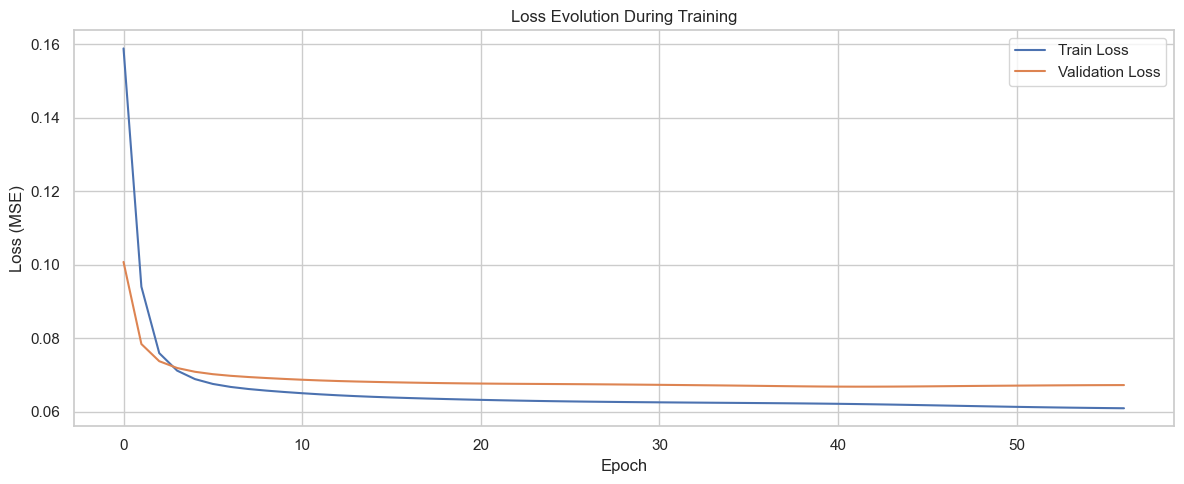

In [97]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()

# Save figure
os.makedirs('prediction_plots_simple_rnn', exist_ok=True)
plt.savefig('prediction_plots_simple_rnn/loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [98]:
print("\nEvaluating model on test data...")

total_mae = 0
total_std = 0
total_max_error = 0
batch_count = 0
n = 20

# Evaluate over n batches from the test set
for i, (x_test, y_test_norm) in enumerate(test_ds.take(n)):
    y_test_norm = y_test_norm.numpy()
    y_pred_norm = model_simple_rnn.predict(x_test).flatten()

    # Denormalize predictions and targets
    y_test = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()

    # Compute metrics
    mae = np.mean(np.abs(y_test - y_pred))
    std = np.std(y_test - y_pred)
    max_error = np.max(np.abs(y_test - y_pred))

    total_mae += mae
    total_std += std
    total_max_error += max_error
    batch_count += 1

    print(f"\nBatch {i+1} — Performance (bpm):")
    print(f"- MAE: {mae:.1f}")
    print(f"- Std of error: {std:.1f}")
    print(f"- Max error: {max_error:.1f}")

# Average metrics across batches
avg_mae = total_mae / batch_count
avg_std = total_std / batch_count
avg_max_error = total_max_error / batch_count

print("\n" + "="*50)
print("AVERAGE PERFORMANCE OVER 5 BATCHES:")
print(f"- Mean MAE: {avg_mae:.1f} bpm")
print(f"- Mean Std of Error: {avg_std:.1f} bpm")
print(f"- Mean Max Error: {avg_max_error:.1f} bpm")
print("="*50)



Evaluating model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  

Batch 1 — Performance (bpm):
- MAE: 4.8
- Std of error: 6.0
- Max error: 16.2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Batch 2 — Performance (bpm):
- MAE: 1.8
- Std of error: 2.3
- Max error: 7.8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Batch 3 — Performance (bpm):
- MAE: 1.5
- Std of error: 1.9
- Max error: 5.3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Batch 4 — Performance (bpm):
- MAE: 2.8
- Std of error: 3.8
- Max error: 11.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Batch 5 — Performance (bpm):
- MAE: 1.9
- Std of error: 2.4
- Max error: 6.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Batch 6 — Performance (bpm):
- MAE: 2.2
- Std of error: 3.4
- Max error: 13.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Batch 7 — Performance (bpm):
- MAE: 2.0
- Std of error: 2.3
- Max error: 7.9
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Batch 8 — Performance (bpm):
- MAE: 2.2
- Std of error: 2.8
- Max error: 7.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


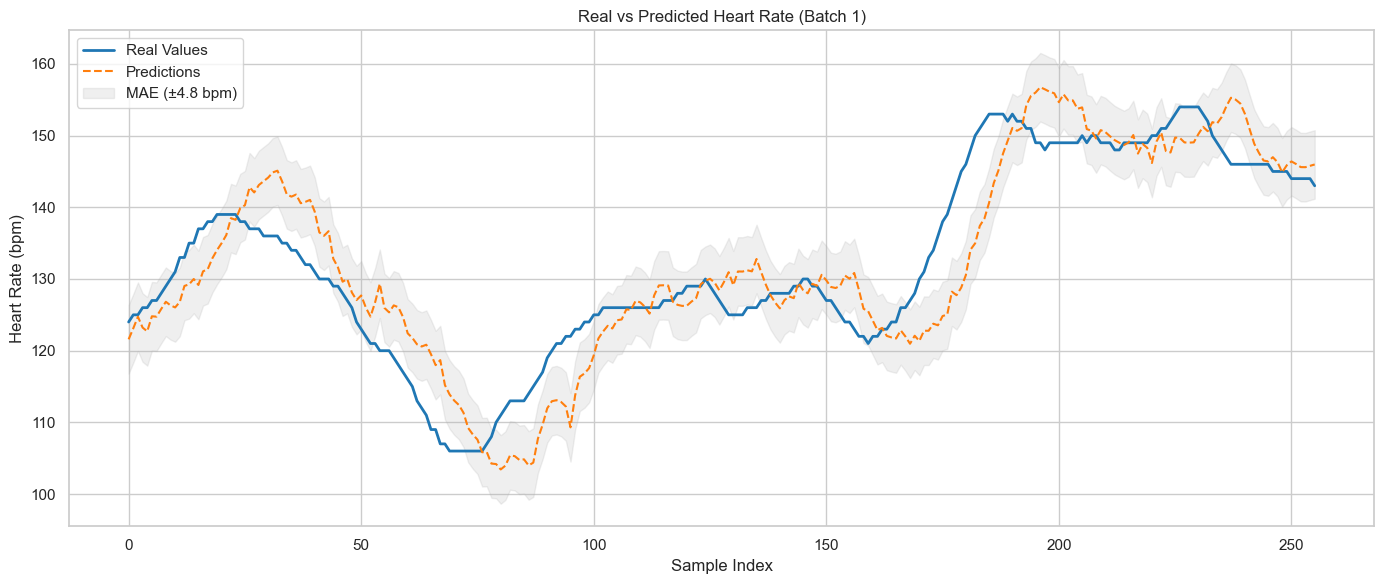

Batch 1 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


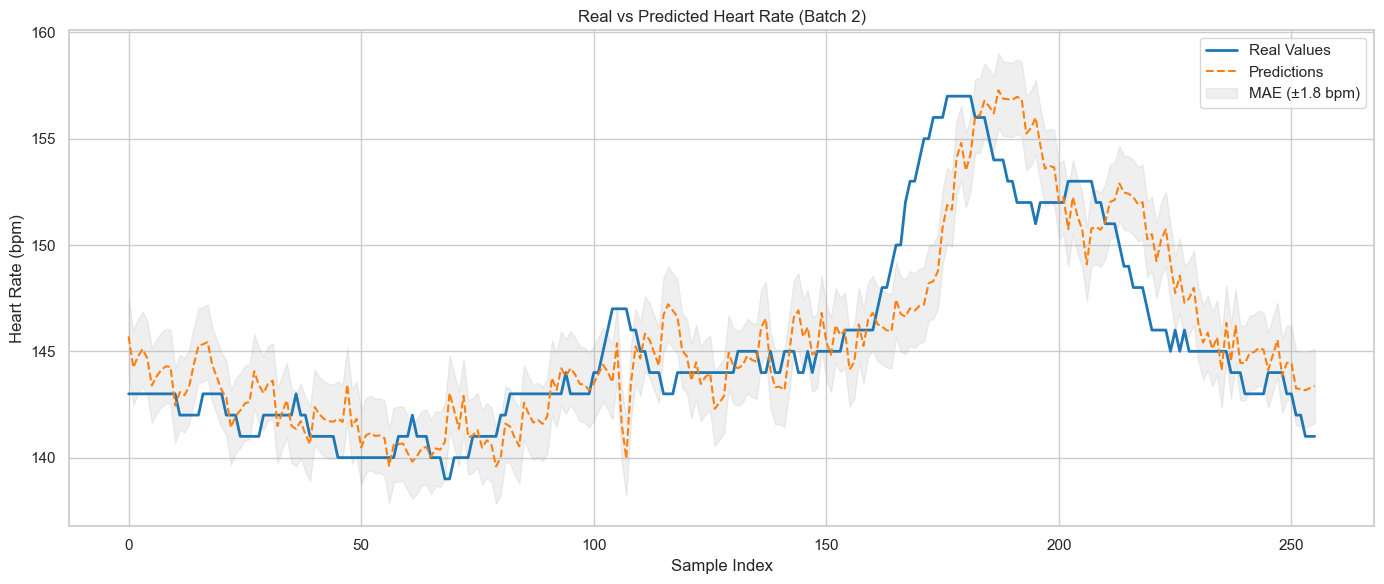

Batch 2 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


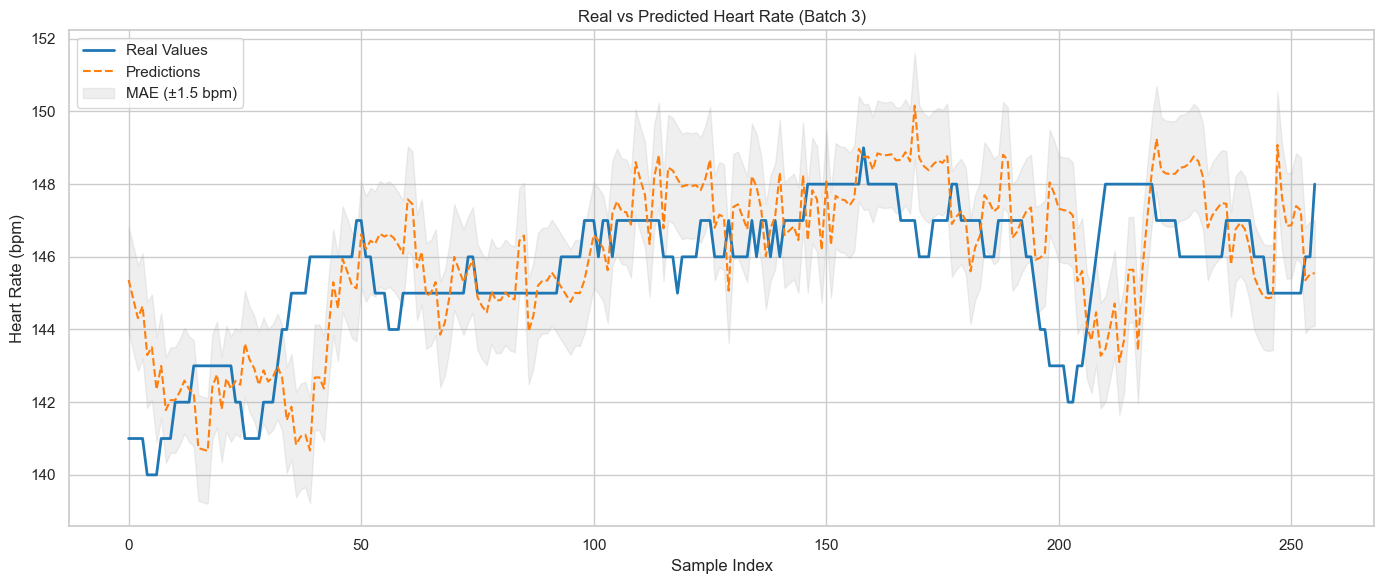

Batch 3 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


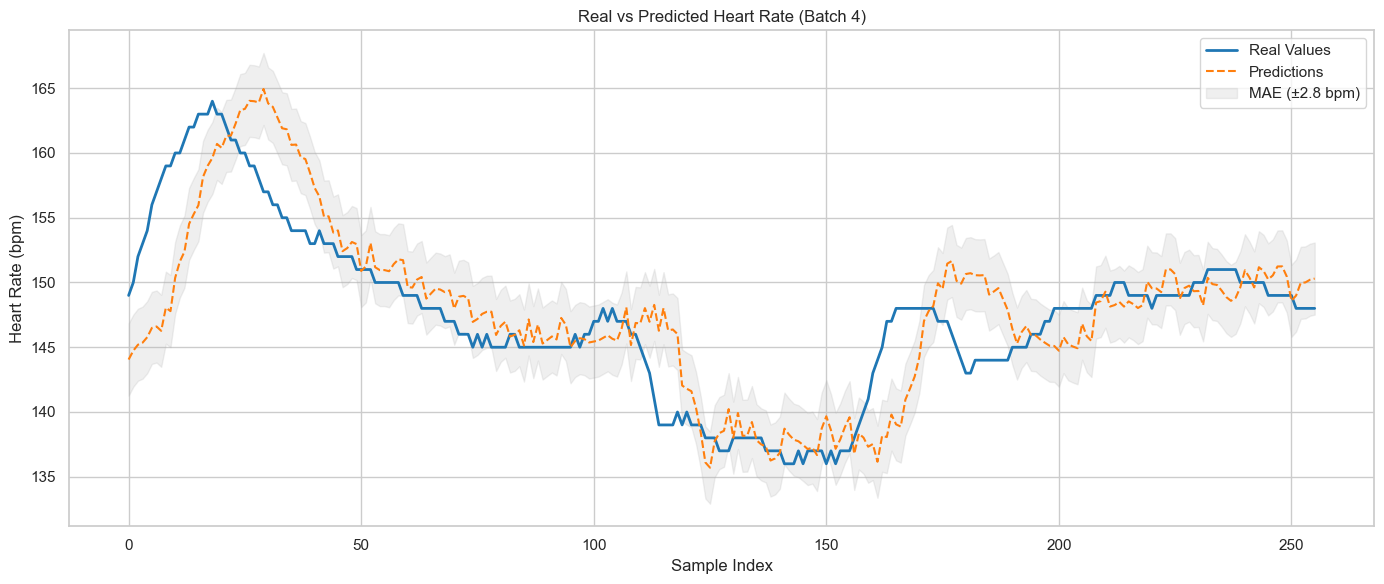

Batch 4 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


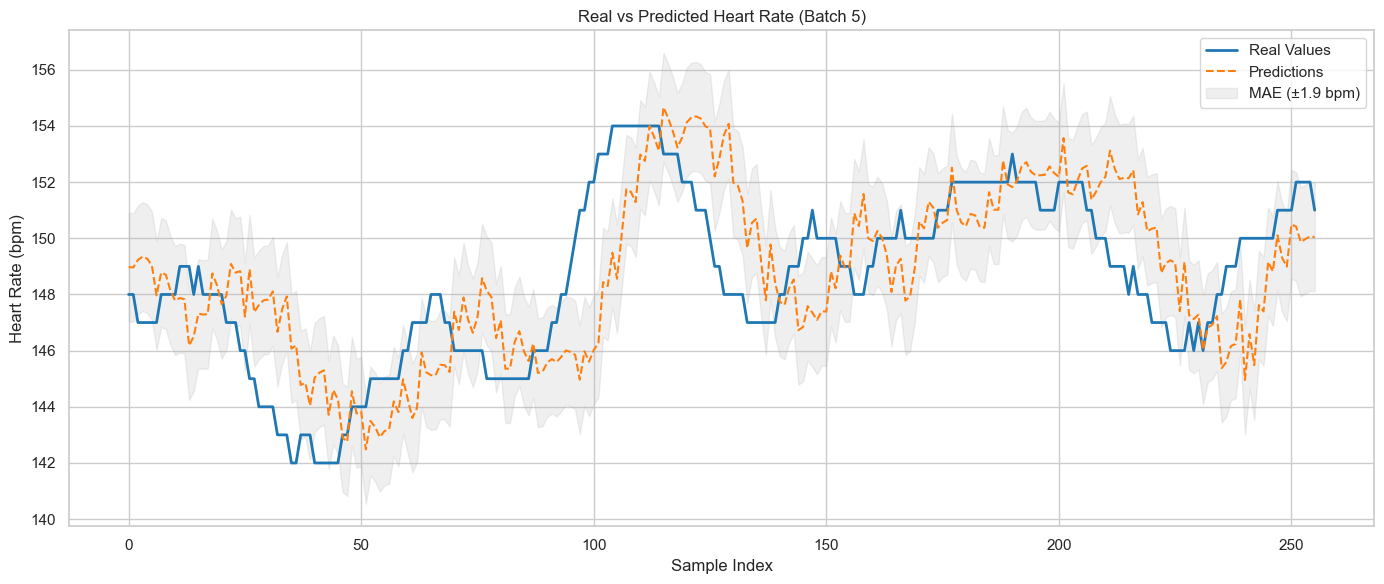

Batch 5 saved:


In [99]:
# Create output directory if it doesn't exist
output_dir = 'prediction_plots_simple_rnn'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set(style='whitegrid')
plt.rcParams['font.size'] = 12

# Colors
color_real = '#1f77b4'      # blue
color_pred = '#ff7f0e'      # orange
color_error = '#b0b0b0'     # light gray

# Process 5 batches from test set
for i, batch in enumerate(test_ds.take(5)):
    x_test, y_test_norm = batch
    y_test_norm = y_test_norm.numpy()
    
    # Get predictions
    y_pred_norm = model_simple_rnn.predict(x_test).flatten()
    
    # Convert back to original scale
    y_test_real = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred_real = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    
    # Calculate MAE
    mae_bpm = np.mean(np.abs(y_test_real - y_pred_real))
    n_samples = len(y_test_real)

    # ===== LINE PLOT =====
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Real Values', color=color_real, linewidth=2)
    plt.plot(y_pred_real, label='Predictions', color=color_pred, linestyle='--', linewidth=1.5)
    
    # Add error band
    plt.fill_between(
        range(n_samples),
        y_pred_real - mae_bpm,
        y_pred_real + mae_bpm,
        color=color_error,
        alpha=0.2,
        label=f'MAE (±{mae_bpm:.1f} bpm)'
    )
    
    plt.title(f'Real vs Predicted Heart Rate (Batch {i+1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plots
    line_pdf = os.path.join(output_dir, f'predictions_batch_{i+1}.pdf')
    plt.savefig(line_pdf)
    plt.show()

    print(f"Batch {i+1} saved:")

## Long$-$Short Term Memory (LSTM)

### Arquitectura del model: LSTM

Es defineix un **model Long$-$Short Term Memory (LSTM)** per a la predicció de la freqüència cardíaca a partir de seqüències temporals de variables fisiològiques.

- **Entrada**: seqüències de longitud fixa amb diverses característiques (*features*).
- **Capa LSTM oculta**: amb 4 neurones i activació `tanh`.
- **Capa de sortida**: una única neurona amb activació lineal per predicció contínua.
- El model es compila amb:
  - Optimitzador `Adam`
  - Pèrdua `mean squared error (mse)`
  - Mètriques: `mae` i `mse`


In [101]:
def build_LSTM(input_shape):
    """
    Build a LSTM for time series regression.
    """
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.LSTM(4, activation='tanh', recurrent_activation="sigmoid")(inputs)
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

In [102]:
# 1. Input shape
input_shape = ds_info['input_shape']
print(f"\nModel input shape: {input_shape}")

# 2. Build the LSTM model
model_LSTM = build_LSTM(input_shape)
model_LSTM.summary()

# 3. Get callbacks
callbacks = get_callbacks(
    checkpoint_path="best_model_LSMT.weights.h5",
    log_dir='./logs/LSTM'
)

# 4. Train the model
print("\nStarting LSTM training...")
history = model_LSTM.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


Model input shape: (60, 4)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 60, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4)                   │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149 (596.00 B)

 Trainable params: 149 (596.00 B)

 Non-trainable params: 0 (0.00 B)


Starting LSTM training...
Epoch 1/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.9355 - mae: 0.7406 - mse: 0.9355 - val_loss: 0.1782 - val_mae: 0.2907 - val_mse: 0.1782
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.1436 - mae: 0.2528 - mse: 0.1436 - val_loss: 0.0906 - val_mae: 0.2065 - val_mse: 0.0906
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0827 - mae: 0.1908 - mse: 0.0827 - val_loss: 0.0783 - val_mae: 0.1922 - val_mse: 0.0783
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0706 - mae: 0.1758 - mse: 0.0706 - val_loss: 0.0732 - val_mae: 0.1857 - val_mse: 0.0732
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0654 - mae: 0.1684 - mse: 0.0654 - val_loss: 0.0705 - val_mae: 0.1817 - val_mse: 0.0705
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0627 - mae: 0.1643 - mse: 0.0627 - val_loss: 0.0690 - val_mae: 0.1795 - val_mse: 0.0690
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 

### Avaluació del model

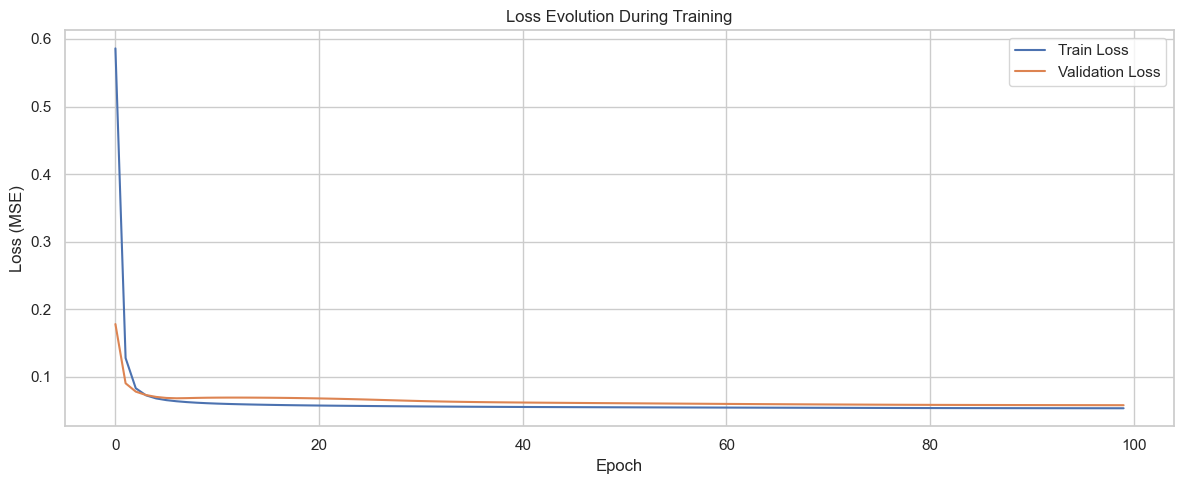

In [103]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()

# Save figure
os.makedirs('prediction_plots_LSTM', exist_ok=True)
plt.savefig('prediction_plots_LSTM/loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [104]:
print("\nEvaluating model on test data...")

total_mae = 0
total_std = 0
total_max_error = 0
batch_count = 0
n = 20

# Evaluate over n batches from the test set
for i, (x_test, y_test_norm) in enumerate(test_ds.take(n)):
    y_test_norm = y_test_norm.numpy()
    y_pred_norm = model_LSTM.predict(x_test).flatten()

    # Denormalize predictions and targets
    y_test = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()

    # Compute metrics
    mae = np.mean(np.abs(y_test - y_pred))
    std = np.std(y_test - y_pred)
    max_error = np.max(np.abs(y_test - y_pred))

    total_mae += mae
    total_std += std
    total_max_error += max_error
    batch_count += 1

    print(f"\nBatch {i+1} — Performance (bpm):")
    print(f"- MAE: {mae:.1f}")
    print(f"- Std of error: {std:.1f}")
    print(f"- Max error: {max_error:.1f}")

# Average metrics across batches
avg_mae = total_mae / batch_count
avg_std = total_std / batch_count
avg_max_error = total_max_error / batch_count

print("\n" + "="*50)
print("AVERAGE PERFORMANCE OVER 5 BATCHES:")
print(f"- Mean MAE: {avg_mae:.1f} bpm")
print(f"- Mean Std of Error: {avg_std:.1f} bpm")
print(f"- Mean Max Error: {avg_max_error:.1f} bpm")
print("="*50)


Evaluating model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

Batch 1 — Performance (bpm):
- MAE: 3.8
- Std of error: 4.7
- Max error: 13.4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Batch 2 — Performance (bpm):
- MAE: 1.8
- Std of error: 2.4
- Max error: 8.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Batch 3 — Performance (bpm):
- MAE: 1.5
- Std of error: 1.9
- Max error: 5.7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Batch 4 — Performance (bpm):
- MAE: 2.5
- Std of error: 3.4
- Max error: 10.6
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Batch 5 — Performance (bpm):
- MAE: 1.8
- Std of error: 2.2
- Max error: 7.3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Batch 6 — Performance (bpm):
- MAE: 2.1
- Std of error: 3.2
- Max error: 16.1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Batch 7 — Performance (bpm):
- MAE: 1.9
- Std of error: 2.4
- Max error: 8.4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Batch 8 — Performance (bpm):
- MAE: 2.3
- Std of error: 2.9
- Max error: 9.4
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/s

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


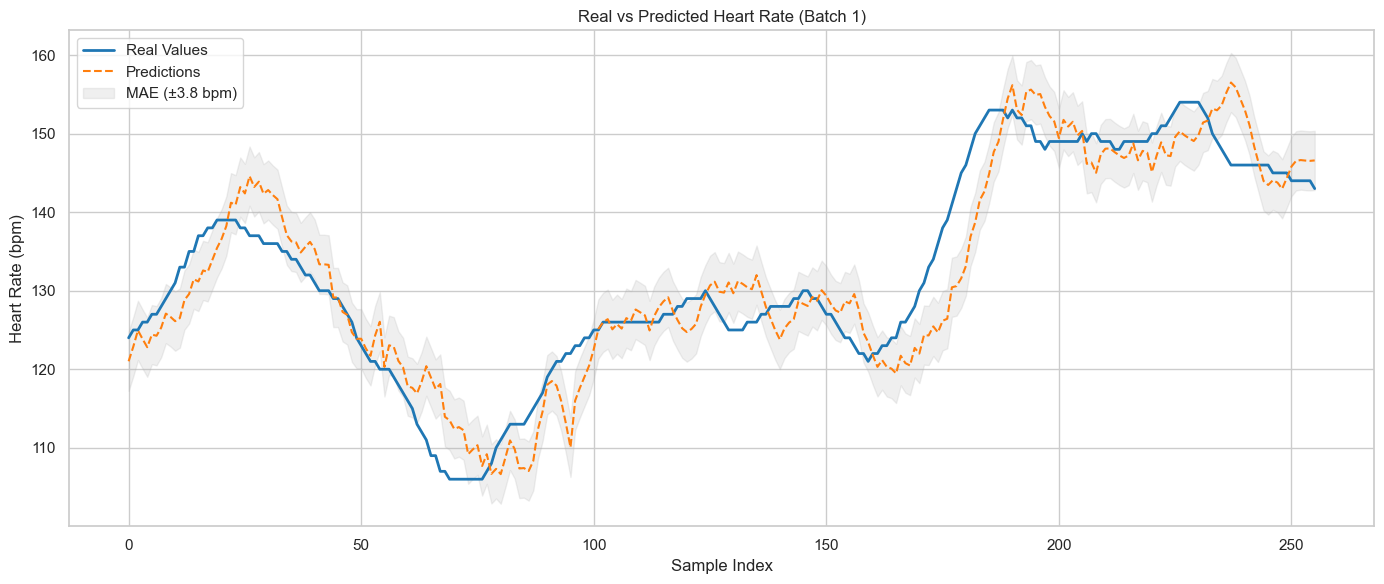

Batch 1 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


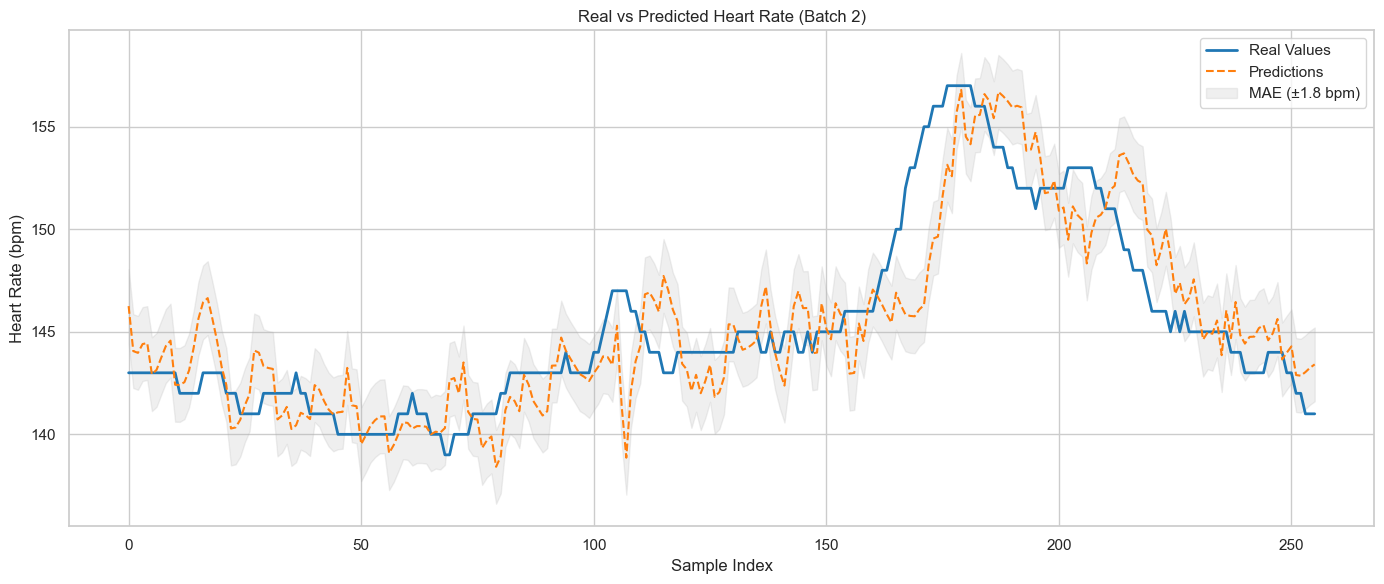

Batch 2 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


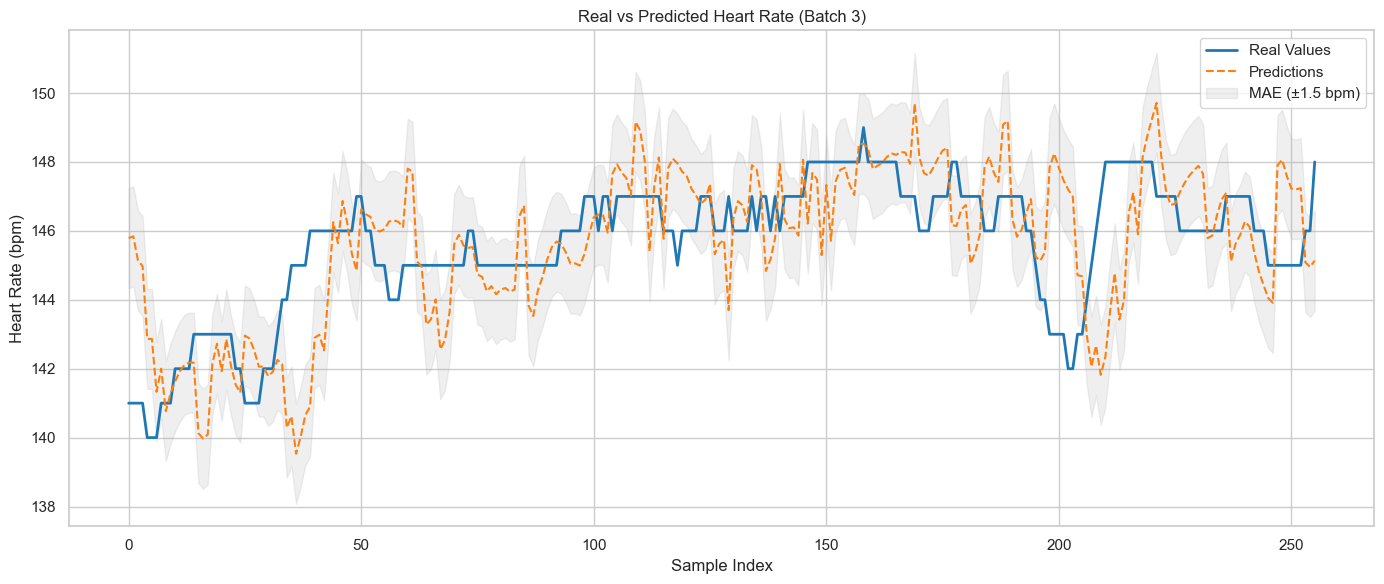

Batch 3 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


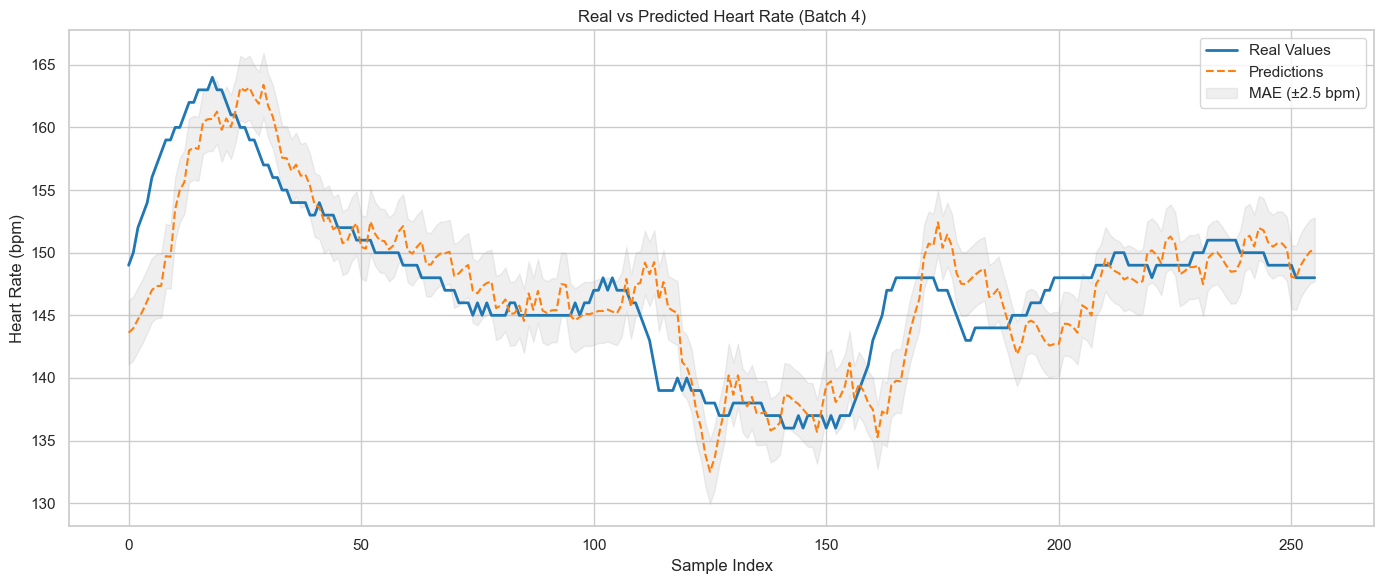

Batch 4 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


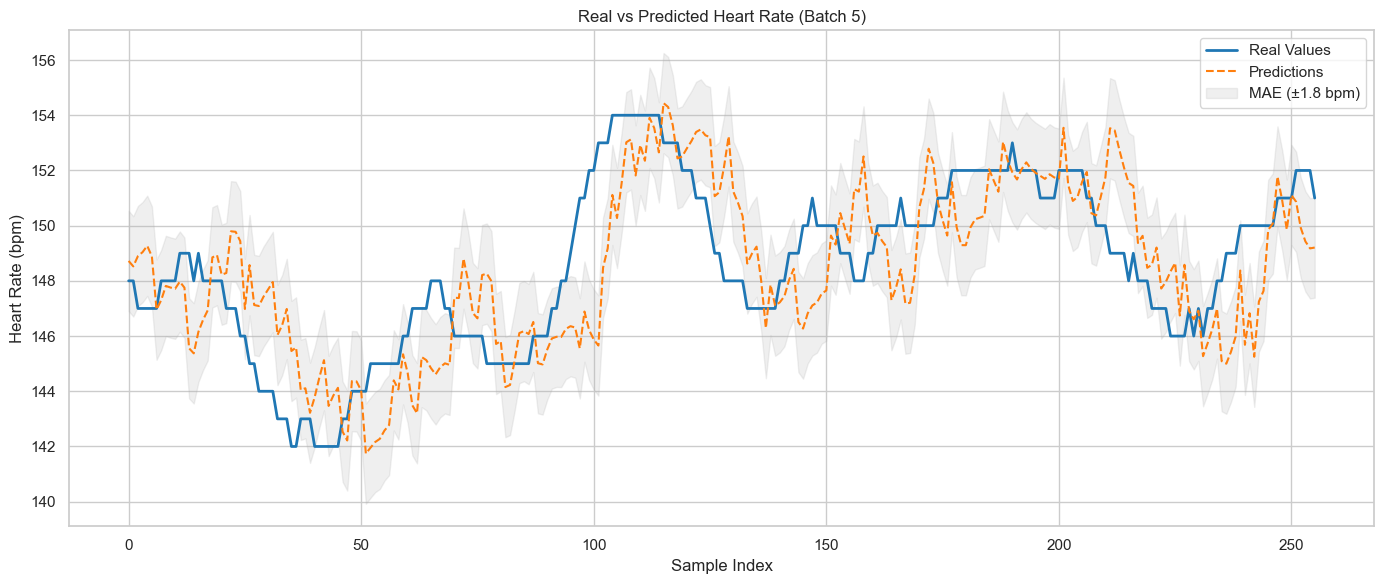

Batch 5 saved:


In [105]:
# Create output directory if it doesn't exist
output_dir = 'prediction_plots_LSTM'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set(style='whitegrid')
plt.rcParams['font.size'] = 12

# Colors
color_real = '#1f77b4'      # blue
color_pred = '#ff7f0e'      # orange
color_error = '#b0b0b0'     # light gray

# Process 5 batches from test set
for i, batch in enumerate(test_ds.take(5)):
    x_test, y_test_norm = batch
    y_test_norm = y_test_norm.numpy()
    
    # Get predictions
    y_pred_norm = model_LSTM.predict(x_test).flatten()
    
    # Convert back to original scale
    y_test_real = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred_real = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    
    # Calculate MAE
    mae_bpm = np.mean(np.abs(y_test_real - y_pred_real))
    n_samples = len(y_test_real)

    # ===== LINE PLOT =====
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Real Values', color=color_real, linewidth=2)
    plt.plot(y_pred_real, label='Predictions', color=color_pred, linestyle='--', linewidth=1.5)
    
    # Add error band
    plt.fill_between(
        range(n_samples),
        y_pred_real - mae_bpm,
        y_pred_real + mae_bpm,
        color=color_error,
        alpha=0.2,
        label=f'MAE (±{mae_bpm:.1f} bpm)'
    )
    
    plt.title(f'Real vs Predicted Heart Rate (Batch {i+1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plots
    line_pdf = os.path.join(output_dir, f'predictions_batch_{i+1}.pdf')
    plt.savefig(line_pdf)
    plt.show()

    print(f"Batch {i+1} saved:")

## Fitxer FTP

In [107]:
df_ftp = pd.read_csv("ftp_20_min.csv")

selected_columns = ['heart_rate', 'power_ma', 'cadence', 'rolling_ave_alt']
target_array_ftp, feature_array_ftp = prepare_arrays(df_ftp, feature_cols=selected_columns)

target_norm_ftp, feature_norm_ftp, _ = normalize_arrays(target_array_ftp, feature_array_ftp)

ftp_ds = keras.utils.timeseries_dataset_from_array(
    feature_norm_ftp[:-30], 
    targets=target_norm_ftp[30:],
    sampling_rate=1, 
    sequence_length=15, 
    batch_size=256,
    shuffle=False
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


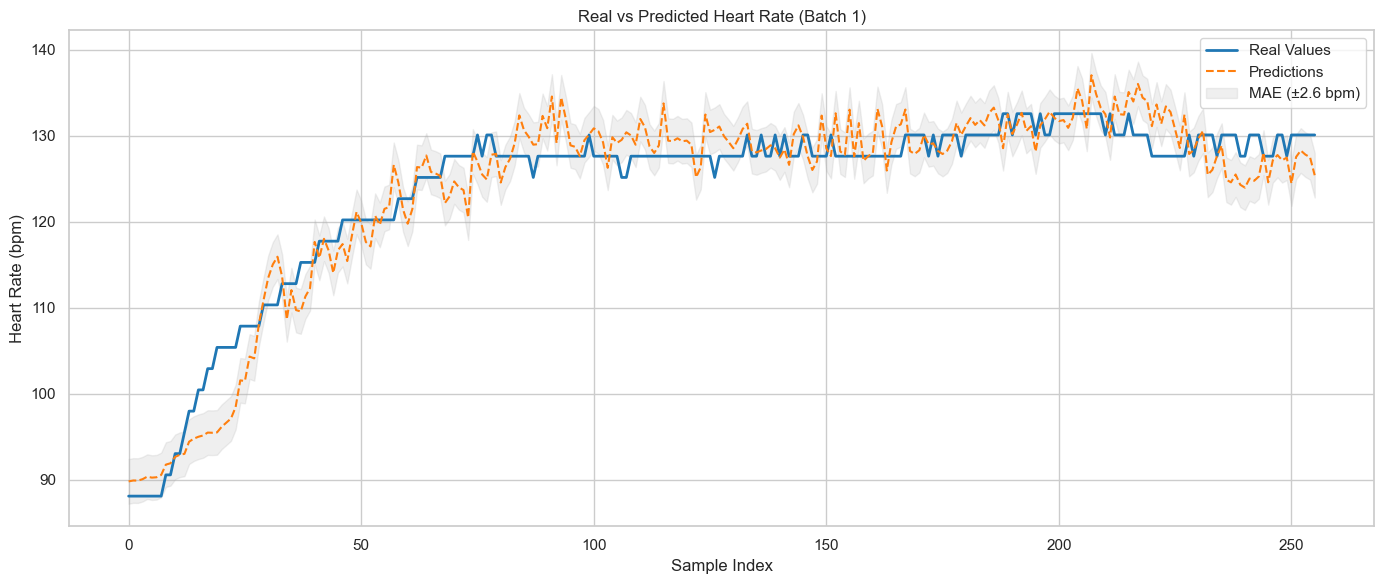

Batch 1 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


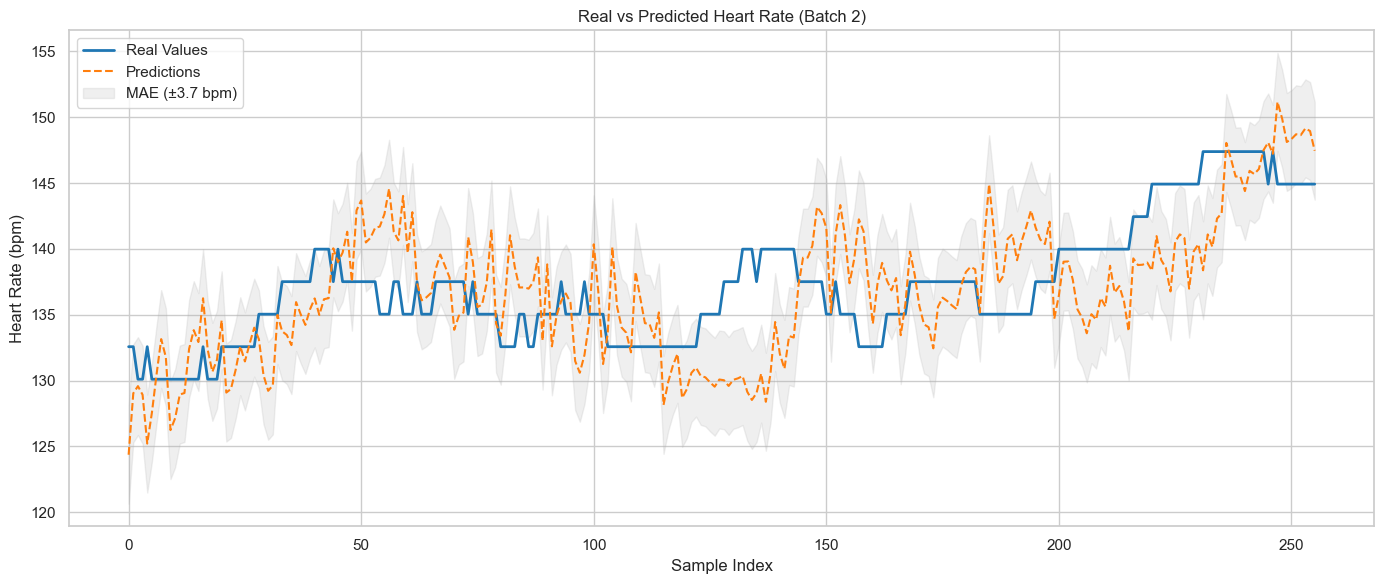

Batch 2 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


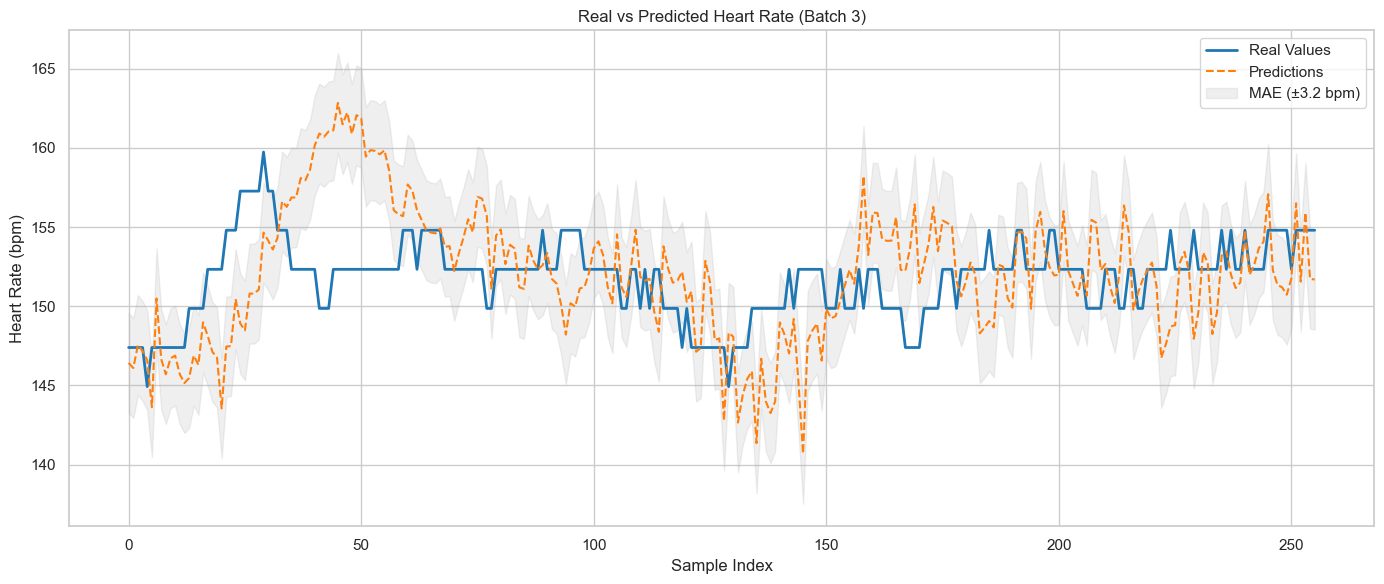

Batch 3 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


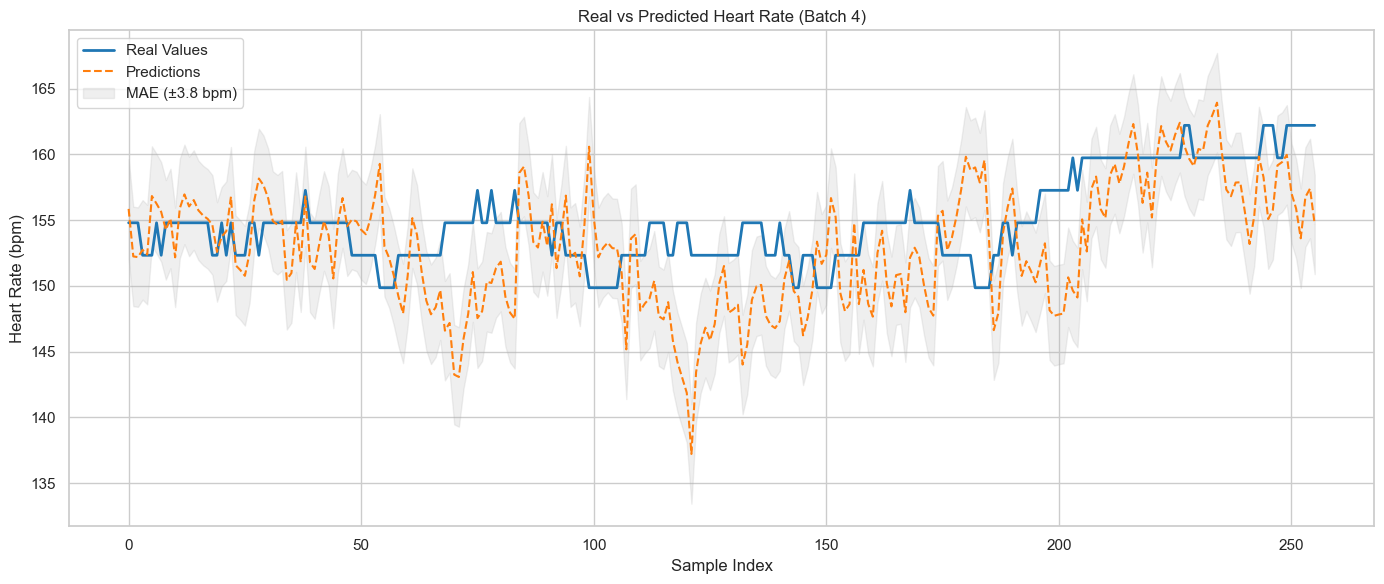

Batch 4 saved:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


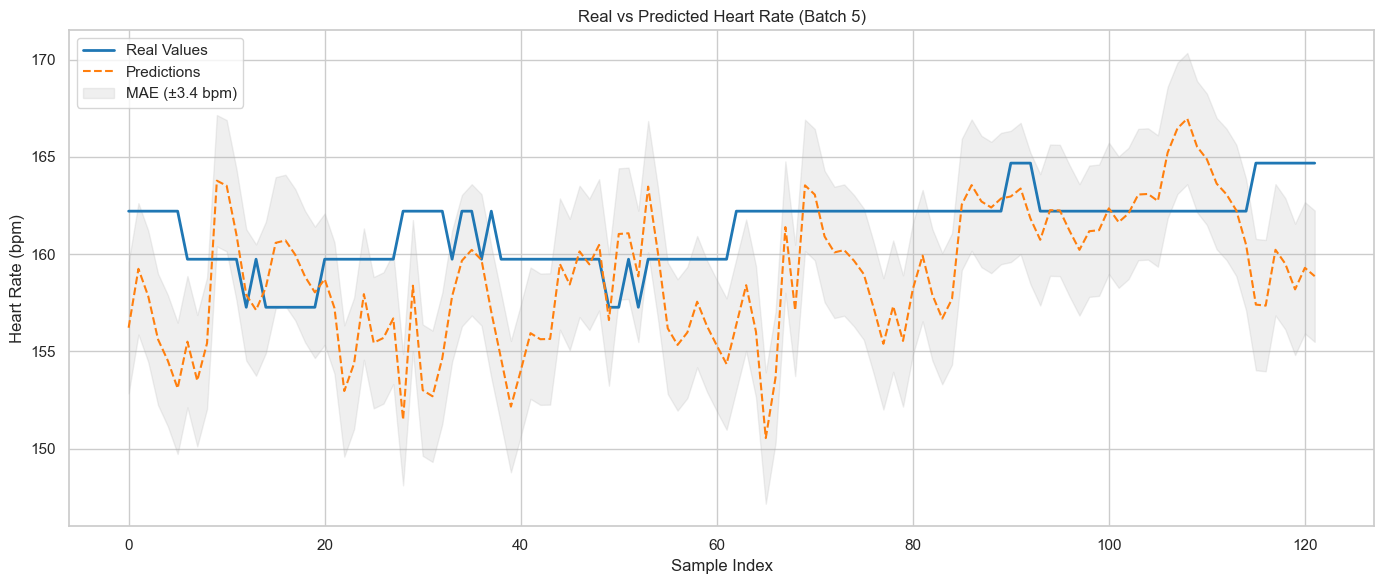

Batch 5 saved:


In [108]:
# Create output directory if it doesn't exist
output_dir = 'prediction_plots_simple_rnn'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set(style='whitegrid')
plt.rcParams['font.size'] = 12

# Colors
color_real = '#1f77b4'      # blue
color_pred = '#ff7f0e'      # orange
color_error = '#b0b0b0'     # light gray

# Process 5 batches from test set
for i, batch in enumerate(ftp_ds.take(5)):
    x_test, y_test_norm = batch
    y_test_norm = y_test_norm.numpy()
    
    # Get predictions
    y_pred_norm = model_simple_rnn.predict(x_test).flatten()
    
    # Convert back to original scale
    y_test_real = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred_real = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    
    # Calculate MAE
    mae_bpm = np.mean(np.abs(y_test_real - y_pred_real))
    n_samples = len(y_test_real)

    # ===== LINE PLOT =====
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Real Values', color=color_real, linewidth=2)
    plt.plot(y_pred_real, label='Predictions', color=color_pred, linestyle='--', linewidth=1.5)
    
    # Add error band
    plt.fill_between(
        range(n_samples),
        y_pred_real - mae_bpm,
        y_pred_real + mae_bpm,
        color=color_error,
        alpha=0.2,
        label=f'MAE (±{mae_bpm:.1f} bpm)'
    )
    
    plt.title(f'Real vs Predicted Heart Rate (Batch {i+1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plots
    line_pdf = os.path.join(output_dir, f'predictions_ftp_batch_{i+1}.pdf')
    plt.savefig(line_pdf)
    plt.show()

    print(f"Batch {i+1} saved:")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


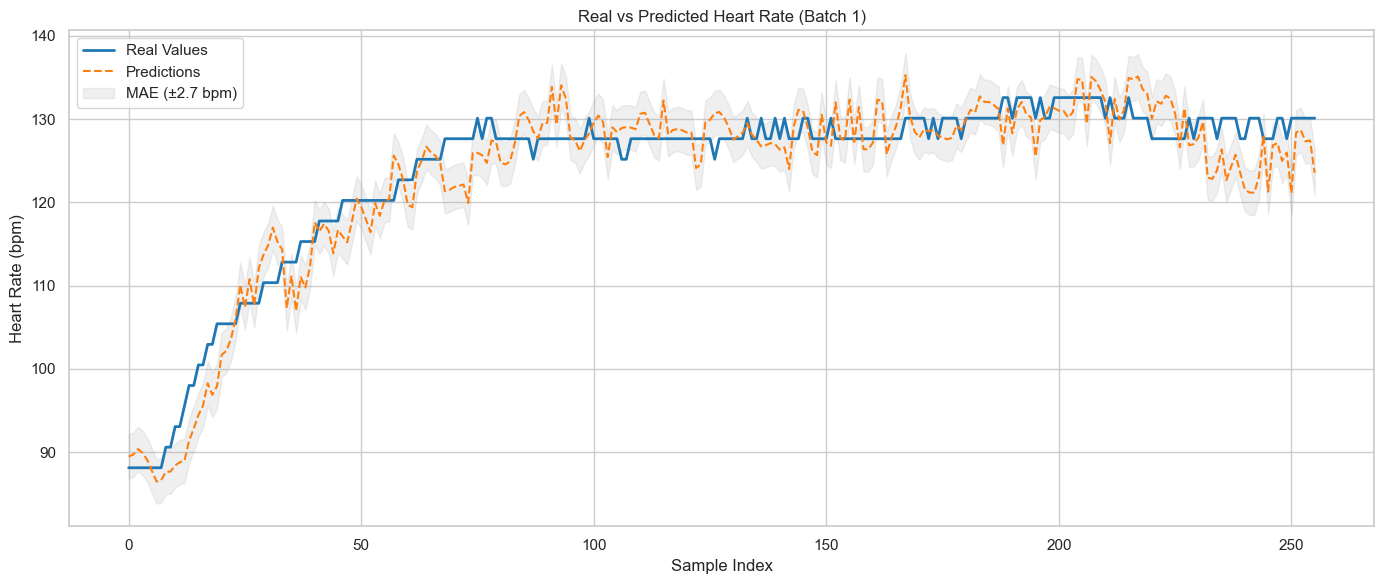

Batch 1 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


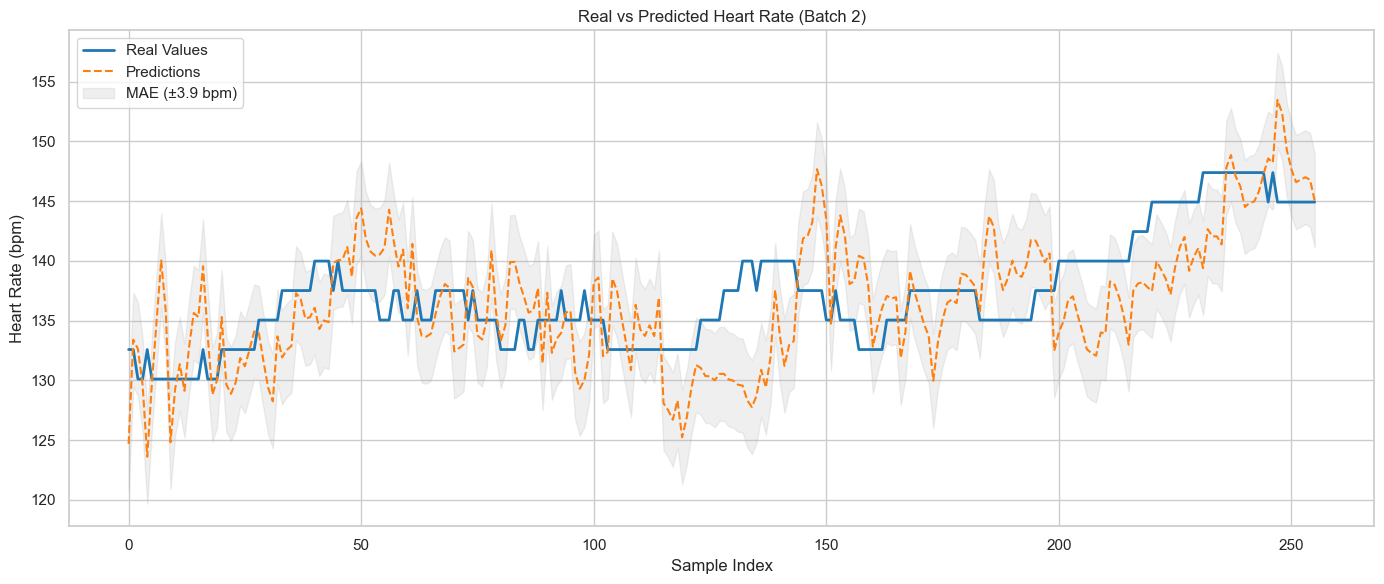

Batch 2 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


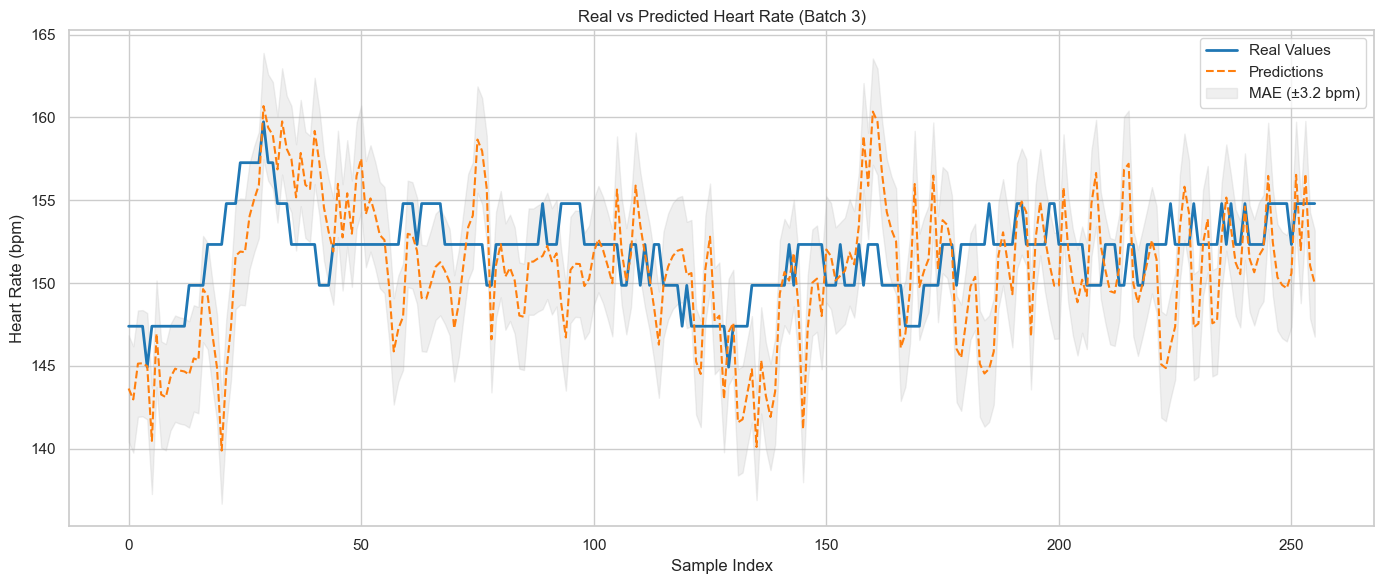

Batch 3 saved:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


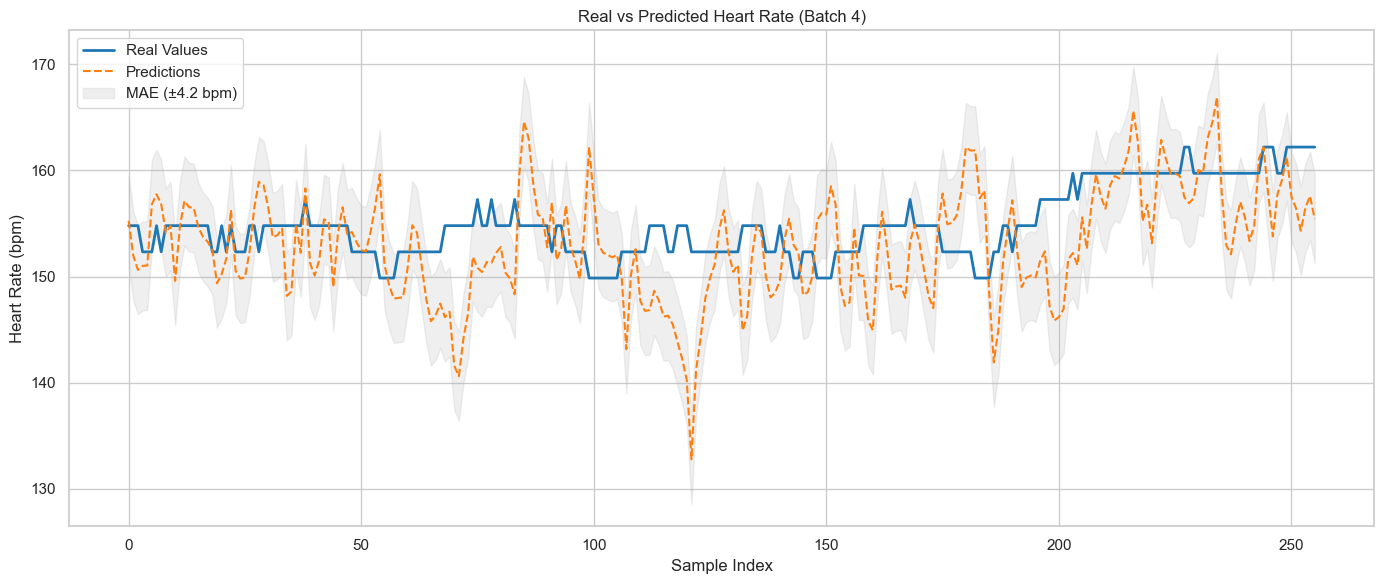

Batch 4 saved:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


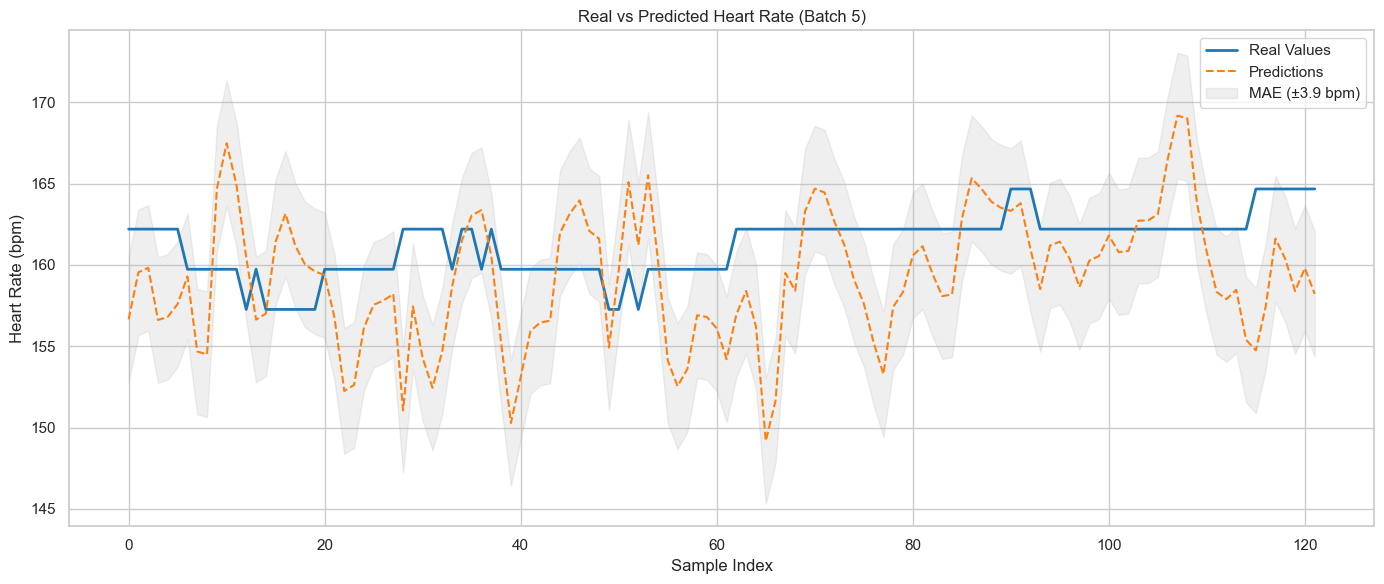

Batch 5 saved:


In [109]:
# Create output directory if it doesn't exist
output_dir = 'prediction_plots_LSTM'
os.makedirs(output_dir, exist_ok=True)

# Set style
sns.set(style='whitegrid')
plt.rcParams['font.size'] = 12

# Colors
color_real = '#1f77b4'      # blue
color_pred = '#ff7f0e'      # orange
color_error = '#b0b0b0'     # light gray

# Process 5 batches from test set
for i, batch in enumerate(ftp_ds.take(5)):
    x_test, y_test_norm = batch
    y_test_norm = y_test_norm.numpy()
    
    # Get predictions
    y_pred_norm = model_LSTM.predict(x_test).flatten()
    
    # Convert back to original scale
    y_test_real = scalers[0].inverse_transform(y_test_norm.reshape(-1, 1)).flatten()
    y_pred_real = scalers[0].inverse_transform(y_pred_norm.reshape(-1, 1)).flatten()
    
    # Calculate MAE
    mae_bpm = np.mean(np.abs(y_test_real - y_pred_real))
    n_samples = len(y_test_real)

    # ===== LINE PLOT =====
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_real, label='Real Values', color=color_real, linewidth=2)
    plt.plot(y_pred_real, label='Predictions', color=color_pred, linestyle='--', linewidth=1.5)
    
    # Add error band
    plt.fill_between(
        range(n_samples),
        y_pred_real - mae_bpm,
        y_pred_real + mae_bpm,
        color=color_error,
        alpha=0.2,
        label=f'MAE (±{mae_bpm:.1f} bpm)'
    )
    
    plt.title(f'Real vs Predicted Heart Rate (Batch {i+1})')
    plt.xlabel('Sample Index')
    plt.ylabel('Heart Rate (bpm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plots
    line_pdf = os.path.join(output_dir, f'predictions_ftp_batch_{i+1}.pdf')
    plt.savefig(line_pdf)
    plt.show()

    print(f"Batch {i+1} saved:")